# Malay-5-class-Consumer-Complaints classification by multilingual BERT


## 1.Import library

In [ ]:
!nvidia-smi

Wed Apr 27 09:36:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip3 install tensorflow_text>=2.0.0rc0

In [ ]:
pip install googletrans==4.0.0-rc1

     |████████████████████████████████| 55 kB 3.6 MB/s 
     |████████████████████████████████| 1.3 MB 32.2 MB/s 
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
     |████████████████████████████████| 65 kB 3.9 MB/s 
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17416 sha256=df73496221aa26d24fa168880b18d78cb8852344ad07ef71a3aa009a95e8da07
  Stored in directory: /root/.cache/pip/wheels/43/34/00/4fe71786ea6d12314b29037620c36d857e5d104ac2748bf82a
Successfully built googletrans


In [ ]:
!pip install pandas_summary

In [ ]:
import os
import h5py
import time
import glob
import json
import csv
import datetime
import random
import string
import pickle
import imageio
import cv2
import re
import sys
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import tensorflow_text as text 
#from tensorflow_docs.vis import embed
from tensorflow.keras import layers, Sequential, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Lambda, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm

from IPython.display import Image
%matplotlib inline

tf.random.set_seed(200) 

tf.__version__

'2.8.0'

## 2. Import text data 

In [ ]:
dfv1 = pd.read_csv('Malay_CC_50000v1.csv')
dfv1 =dfv1.iloc[:-1,:] 
dfv1

,index,complaint,Product,label,Malay
0,52,This account was opened & closed without my ac...,Checking or savings account,1,Akaun ini dibuka & ditutup tanpa pengakuan say...
1,144,I applied for a home construction loan through...,Mortgage,4,Saya memohon pinjaman pembinaan rumah melalui ...
2,190,Distributions from XXXX to my XXXX at Suntrust...,Checking or savings account,1,Pengagihan dari XXXX ke XXXX saya di SunTrust ...
3,254,Had a heated conversation with bank manager ab...,Checking or savings account,1,Mempunyai perbualan yang hangat dengan penguru...
4,375,Bank of America did not make the County proper...,Mortgage,4,Bank of America tidak membuat pembayaran cukai...
...,...,...,...,...,...
49994,840472,In response to another CFPB complaint that was...,Checking or savings account,1,Sebagai tindak balas kepada aduan CFPB yang la...
49995,840490,I called on XX/XX/XXXX regarding fraud on my C...,Credit card,3,Saya memanggil XX/XX/XXXX mengenai penipuan pa...
49996,840492,Bank Of America. \nTheir smallest accounts for...,Checking or savings account,1,Bank of America.\nAkaun terkecil mereka untuk ...
49997,840571,Huntington Bank states that it will not receiv...,Checking or savings account,1,Huntington Bank menyatakan bahawa ia tidak aka...


In [ ]:
dfv2 = pd.read_csv('Malay_CC_50000v2.csv')
dfv2 =dfv2.iloc[:-1,:] 
dfv2

,index,complaint,Product,label,Malay
0,840665,On XX/XX/2020 I applied for a loan modificatio...,Mortgage,4,Pada XX / XX / 2020 saya memohon pengubahsuaia...
1,840749,First Financial provided bridge and equity loa...,Mortgage,4,First Financial menyediakan jambatan dan pinja...
2,840801,I am trying to remove myself from a joint savi...,Checking or savings account,1,Saya cuba membuang diri dari akaun simpanan be...
3,840802,I deposited a check from another bank that was...,Checking or savings account,1,Saya mendepositkan cek dari bank lain yang dit...
4,840830,I never received my escrow refund in XXXX and ...,Mortgage,4,Saya tidak pernah menerima bayaran balik escro...
...,...,...,...,...,...
49994,1623448,"I deposited a check for XXXX on XX/XX/2021, at...",Checking or savings account,1,Saya mendepositkan cek untuk xxxx pada xx/xx/2...
49995,1623456,I received a call from Midamerica Mortgage a f...,Mortgage,4,Saya menerima panggilan dari Midamerica Mortga...
49996,1623511,"CIT Bank, a bank that acquired ONE WEST Bank, ...",Mortgage,4,"CIT Bank, sebuah bank yang memperoleh satu Teb..."
49997,1623522,Wells fargo doesnt send updates to an app i us...,Checking or savings account,1,Wells Fargo tidak menghantar kemas kini ke apl...


In [ ]:
dfv3 = pd.read_csv('Malay_CC_70000v3.csv')
dfv3 =dfv3.iloc[:-1,:] 
dfv3

,index,complaint,Product,label,Malay
0,1623573,I use XXXX to get extra cash but chase ban...,Checking or savings account,1,Saya menggunakan xxxx untuk mendapatkan wang t...
1,1623586,NETCREDIT made false statements to cfpb. I sus...,Credit card,3,Netcredit membuat kenyataan palsu kepada CFPB....
2,1623607,"on XXXX XXXX, 2016 I took {$280.00} from my ac...",Checking or savings account,1,"Pada XXXX XXXX, 2016 Saya mengambil {$ 280.00}..."
3,1623628,I have 3 issues with Wells Fargo : 1 . Failur...,Checking or savings account,1,Saya mempunyai 3 masalah dengan Wells Fargo: 1...
4,1623637,"QWR "" Qualified Written Request '' under RESPA...",Mortgage,4,"QWR ""permintaan bertulis yang berkelayakan '' ..."
...,...,...,...,...,...
77179,2599791,Near the end of XXXX 2016 I opened a Citigold ...,Bank account or service,0,Berhampiran akhir xxxx 2016 Saya membuka akaun...
77180,2599794,Caliber Home Loans ( CHL ) sent confirmation i...,Mortgage,4,Pinjaman Rumah Kaliber (CHL) menghantar penges...
77181,2599796,A reward coupon from XXXX expired and American...,Credit card,3,Kupon ganjaran dari XXXX tamat tempoh dan Amer...
77182,2599799,On XX/XX/XXXX I purchased a XXXX XXXX XXXX XXX...,Consumer Loan,2,On XX/XX/XXXX I purchased a XXXX XXXX XXXX XXX...


In [ ]:
df1  = pd.concat([dfv1,dfv2,dfv3])
df1.reset_index(drop=True)
df1

,index,complaint,Product,label,Malay
0,52,This account was opened & closed without my ac...,Checking or savings account,1,Akaun ini dibuka & ditutup tanpa pengakuan say...
1,144,I applied for a home construction loan through...,Mortgage,4,Saya memohon pinjaman pembinaan rumah melalui ...
2,190,Distributions from XXXX to my XXXX at Suntrust...,Checking or savings account,1,Pengagihan dari XXXX ke XXXX saya di SunTrust ...
3,254,Had a heated conversation with bank manager ab...,Checking or savings account,1,Mempunyai perbualan yang hangat dengan penguru...
4,375,Bank of America did not make the County proper...,Mortgage,4,Bank of America tidak membuat pembayaran cukai...
...,...,...,...,...,...
77179,2599791,Near the end of XXXX 2016 I opened a Citigold ...,Bank account or service,0,Berhampiran akhir xxxx 2016 Saya membuka akaun...
77180,2599794,Caliber Home Loans ( CHL ) sent confirmation i...,Mortgage,4,Pinjaman Rumah Kaliber (CHL) menghantar penges...
77181,2599796,A reward coupon from XXXX expired and American...,Credit card,3,Kupon ganjaran dari XXXX tamat tempoh dan Amer...
77182,2599799,On XX/XX/XXXX I purchased a XXXX XXXX XXXX XXX...,Consumer Loan,2,On XX/XX/XXXX I purchased a XXXX XXXX XXXX XXX...


In [ ]:
df1['Product'].value_counts()

Mortgage                       90395
Checking or savings account    43595
Credit card                    18838
Bank account or service        14885
Consumer Loan                   9469
Name: Product, dtype: int64

In [ ]:
df=df1[df1['Malay']!= "error"]
df.reset_index(inplace=True, drop=True)
df

,index,complaint,Product,label,Malay
0,52,This account was opened & closed without my ac...,Checking or savings account,1,Akaun ini dibuka & ditutup tanpa pengakuan say...
1,144,I applied for a home construction loan through...,Mortgage,4,Saya memohon pinjaman pembinaan rumah melalui ...
2,190,Distributions from XXXX to my XXXX at Suntrust...,Checking or savings account,1,Pengagihan dari XXXX ke XXXX saya di SunTrust ...
3,254,Had a heated conversation with bank manager ab...,Checking or savings account,1,Mempunyai perbualan yang hangat dengan penguru...
4,375,Bank of America did not make the County proper...,Mortgage,4,Bank of America tidak membuat pembayaran cukai...
...,...,...,...,...,...
171299,2599791,Near the end of XXXX 2016 I opened a Citigold ...,Bank account or service,0,Berhampiran akhir xxxx 2016 Saya membuka akaun...
171300,2599794,Caliber Home Loans ( CHL ) sent confirmation i...,Mortgage,4,Pinjaman Rumah Kaliber (CHL) menghantar penges...
171301,2599796,A reward coupon from XXXX expired and American...,Credit card,3,Kupon ganjaran dari XXXX tamat tempoh dan Amer...
171302,2599799,On XX/XX/XXXX I purchased a XXXX XXXX XXXX XXX...,Consumer Loan,2,On XX/XX/XXXX I purchased a XXXX XXXX XXXX XXX...


## 3. Preparing data for classification

In [ ]:
from pandas_summary import DataFrameSummary
DataFrameSummary(df).summary()

,index,complaint,Product,label,Malay
count,171304.0,NaN,NaN,171304.0,NaN
mean,1374638.273695,NaN,NaN,2.698723,NaN
std,729294.315032,NaN,NaN,1.492359,NaN
min,52.0,NaN,NaN,0.0,NaN
25%,755272.75,NaN,NaN,1.0,NaN
50%,1403583.0,NaN,NaN,4.0,NaN
75%,1989077.25,NaN,NaN,4.0,NaN
max,2599800.0,NaN,NaN,4.0,NaN
counts,171304,171304,171304,171304,171304
uniques,171304,170964,5,5,171010


In [ ]:
df['Product'].value_counts()

Mortgage                       86309
Checking or savings account    42117
Credit card                    18727
Bank account or service        14767
Consumer Loan                   9384
Name: Product, dtype: int64

Prepare 5000 samples for evaluation

In [ ]:
n=5000
df2=df.sample(n, random_state=100)
df2

,index,complaint,Product,label,Malay
11582,240018,under ID # XXXX filed XX/XX/XXXX with the CFPB...,Mortgage,4,Di bawah ID # xxxx difailkan xx/xx/xxxx dengan...
74618,1284048,I recently became XXXX and got behind on my mo...,Mortgage,4,Saya baru-baru ini menjadi XXXX dan mendapat d...
42710,754414,"Dear CFPB, We are in the process of XXXX and a...",Bank account or service,0,"CFPB yang dihormati, kami sedang dalam proses ..."
136241,2019937,Since XXXX Ocwen Loan Services has taken it up...,Mortgage,4,Sejak Perkhidmatan Pinjaman XXXX Ocwen telah m...
83179,1363268,"Re JPMorgan Chase Bank, N.A. \n\nOn XX/XX/21, ...",Checking or savings account,1,"Re JPMorgan Chase Bank, N.A.\n\nPada xx/xx/21,..."
...,...,...,...,...,...
116602,1939603,Twice I have been charged interest after payin...,Credit card,3,Dua kali saya telah dikenakan faedah selepas m...
116871,1941050,Bank of America Closed my account due to fraud...,Checking or savings account,1,Bank of America menutup akaun saya kerana akti...
158030,2365252,I received notification from my credit monitor...,Checking or savings account,1,Saya menerima pemberitahuan daripada perkhidma...
45127,774700,I recently went through a divorce and financia...,Consumer Loan,2,Saya baru -baru ini menjalani perceraian dan k...


Prepare samples for training and 3000 samples for validation

In [ ]:
df3 = df.drop(df2.index)
df3

,index,complaint,Product,label,Malay
0,52,This account was opened & closed without my ac...,Checking or savings account,1,Akaun ini dibuka & ditutup tanpa pengakuan say...
1,144,I applied for a home construction loan through...,Mortgage,4,Saya memohon pinjaman pembinaan rumah melalui ...
2,190,Distributions from XXXX to my XXXX at Suntrust...,Checking or savings account,1,Pengagihan dari XXXX ke XXXX saya di SunTrust ...
3,254,Had a heated conversation with bank manager ab...,Checking or savings account,1,Mempunyai perbualan yang hangat dengan penguru...
4,375,Bank of America did not make the County proper...,Mortgage,4,Bank of America tidak membuat pembayaran cukai...
...,...,...,...,...,...
171298,2599790,"Dear CFPB, I submitted a complaint against the...",Mortgage,4,"Dear CFPB, saya mengemukakan aduan terhadap se..."
171299,2599791,Near the end of XXXX 2016 I opened a Citigold ...,Bank account or service,0,Berhampiran akhir xxxx 2016 Saya membuka akaun...
171300,2599794,Caliber Home Loans ( CHL ) sent confirmation i...,Mortgage,4,Pinjaman Rumah Kaliber (CHL) menghantar penges...
171301,2599796,A reward coupon from XXXX expired and American...,Credit card,3,Kupon ganjaran dari XXXX tamat tempoh dan Amer...


In [ ]:
nn=153000
df4=df3.sample(nn, random_state=100)
df4.head()

,index,complaint,Product,label,Malay
84758,1387912,Freedom Mortgage has failed to pay my insuranc...,Mortgage,4,Gadai janji kebebasan telah gagal membayar sya...
59406,1042404,Citibank offered me XXXX XXXX XXXX bonus miles...,Checking or savings account,1,Citibank menawarkan saya xxxx xxxx xxxx bonus ...
23224,372860,My name is XXXX XXXX and my mortgage is with W...,Mortgage,4,Nama saya XXXX XXXX dan gadai janji saya denga...
162832,2463108,I am outraged at the subpar level of service p...,Checking or savings account,1,Saya marah pada tahap perkhidmatan subpar yang...
55742,967089,Today XXXX / XXXX / 17 around XXXX polic...,Mortgage,4,Hari ini XXXX / XXXX / 17 Sekitar polis XXXX d...


### Check the distribution of samples

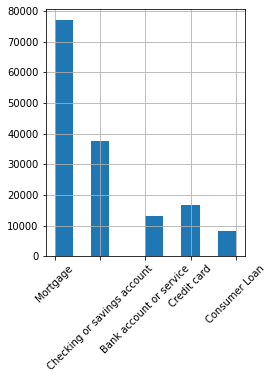

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 4, 4
df4['Product'].hist(); 
plt.tight_layout() 
plt.xticks(rotation=45)
plt.show() 

## 3. Prepare training and validation data


In [ ]:
X_train_raw=df4.loc[:, 'Malay']
X_train_raw=np.array(X_train_raw)

print(X_train_raw.dtype)
print(type(X_train_raw))
print(np.shape(X_train_raw))
print(X_train_raw[0:3])

object
<class 'numpy.ndarray'>
(153000,)
['Gadai janji kebebasan telah gagal membayar syarikat insurans saya dari escrow. Apabila saya menghubungi gadai janji kebebasan mengenai perkara ini, mereka memaklumkan kepada saya bahawa mereka tidak menerima invois dari syarikat insurans. Saya menghubungi syarikat insurans, dan mereka memaklumkan saya bahawa mereka kembali meneruskan dan memfailkan maklumat invois dan pembayaran kepada gadai janji kebebasan di alamat yang sesuai. Dasar insurans saya berisiko untuk pembatalan kerana kegagalan gadai janji kebebasan untuk membuat pembayaran dari escrow dengan tepat pada masanya. Terdapat keseimbangan yang berlebihan dalam akaun escrow yang berkaitan dengan gadai janji saya, dan gadai janji kebebasan masih gagal membuat pembayaran. Saya mungkin kehilangan perlindungan insurans dan berisiko menjadi tiada tempat tinggal akibat cuaca, api atau jumlah kejadian bencana lain jika bil tidak dibayar. Di samping itu, Freedom Mortgage adalah dalam pelanggar

In [ ]:
y_train=df4.loc[:, 'label']
y_train=np.array(y_train)

print(y_train.dtype)
print(type(y_train))
print(np.shape(y_train))
print(y_train[0:3])

int64
<class 'numpy.ndarray'>
(153000,)
[4 1 4]


##  4. Build BERT model

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4",
    trainable=True)
outputs = encoder(encoder_inputs)      # [batch_size, 768].
out=Dense(16, activation='relu')(outputs["pooled_output"])
output=Dense(5, activation='softmax')(out)
model = tf.keras.Model(text_input, output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['input_1[0][0]']                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

### Check how BERT works 

In [ ]:
sentences = tf.constant(["今回の彼の活躍は称賛に値する","His success this time is commendable","他这次的成功值得称赞"])
print(model(sentences).shape)
model(sentences)

(3, 5)


<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[0.0249191 , 0.38669425, 0.16490611, 0.20694798, 0.21653248],
       [0.02444271, 0.38796607, 0.21414709, 0.14414147, 0.22930267],
       [0.04571471, 0.34074447, 0.18099886, 0.21588147, 0.2166605 ]],
      dtype=float32)>

## 5. Train the model

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/2_BERT/BERT/model/model_test/Malay_CC205_20220427.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
t=time.time()

history = model.fit(X_train_raw, y_train, epochs=10, batch_size=32, validation_split=0.01961, callbacks=[model_checkpoint_callback])

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

Epoch 1/10
4688/4688 [==============================] - ETA: 0s - loss: 0.3995 - accuracy: 0.8549
Epoch 1: val_accuracy improved from -inf to 0.88404, saving model to /content/drive/MyDrive/Colab Notebooks/2_BERT/BERT/model/model_test/Malay_CC205_20220427.01-0.88.hdf5
4688/4688 [==============================] - 1566s 331ms/step - loss: 0.3995 - accuracy: 0.8549 - val_loss: 0.3158 - val_accuracy: 0.8840
Epoch 2/10
4688/4688 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.8930
Epoch 2: val_accuracy improved from 0.88404 to 0.89270, saving model to /content/drive/MyDrive/Colab Notebooks/2_BERT/BERT/model/model_test/Malay_CC205_20220427.02-0.89.hdf5
4688/4688 [==============================] - 1549s 331ms/step - loss: 0.2850 - accuracy: 0.8930 - val_loss: 0.2935 - val_accuracy: 0.8927
Epoch 3/10
4688/4688 [==============================] - ETA: 0s - loss: 0.2462 - accuracy: 0.9072
Epoch 3: val_accuracy improved from 0.89270 to 0.90037, saving model to /content/driv

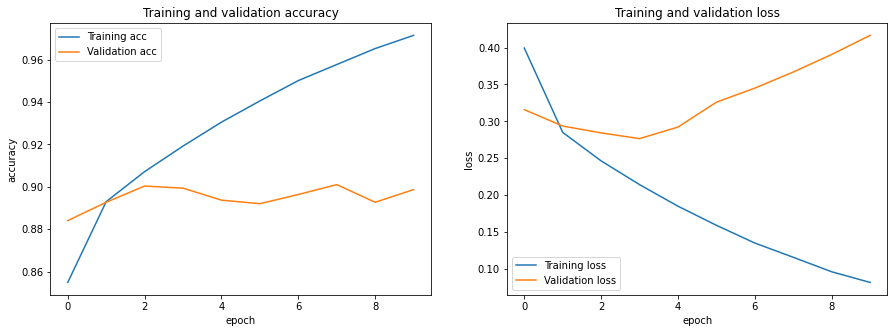

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
            
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.show()

## 6. Evaluate the model with 5000 samples

In [ ]:
X_test_raw=df2.loc[:, 'Malay']
X_test_raw=np.array(X_test_raw)

print(X_test_raw.dtype)
print(type(X_test_raw))
print(np.shape(X_test_raw))
print(X_test_raw[0:3])

object
<class 'numpy.ndarray'>
(5000,)
['Di bawah ID # xxxx difailkan xx/xx/xxxx dengan CFPB saya telah mengadu tentang kesulitan dalam berkomunikasi dengan Wells Fargo.i tidak meminta forBeARANCE dan membuat pembayaran penuh (p & .i. dan escrow) untuk xx/xx/xxxx. Selepas perbincangan dengan xxxx xxxx pejabat excutive Wells Fargo, saya membuat pembayaran faedah sahaja ditambah escrow ({$ 1600.00}) oleh EFT pada xxxx xxxx ke arah pembayaran xx/xx/xxxx. dengan pakar resolusi eksekutif Wells Fargo dengan kumpulan penjagaan dan pemulihan pengguna. Juga dengan pejabat "eksekutif". Saya menerima pengesahan # untuk pembayaran tersebut (xxxx). bercakap. Pada masa itu saya diminta untuk bercakap dengan MS XXXX (sejak saya menelefon lanjutannya, xxxx, tetapi ahwe wqas sebaliknya diduduki. Saya secara khusus menyatakan bahawa pembayaran itu akan digunakan untuk int. Pembayaran> Saya yakin bahawa satu pembayaran akan mencukupi Oday, secara lisan saya dinasihatkan bahawa pembayaran itu tidak diguna

In [ ]:
y_test=df2.loc[:, 'label']
y_test=np.array(y_test)

print(y_test.dtype)
print(type(y_test))
print(np.shape(y_test))
print(y_test[0:3])

int64
<class 'numpy.ndarray'>
(5000,)
[4 4 0]


In [ ]:
X_test_raw.shape

(5000,)

In [ ]:
y_test.shape

(5000,)

In [ ]:
model.load_weights("Malay_CC205_20220427.08-0.90.hdf5")
_, accuracy = model.evaluate(X_test_raw, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

157/157 [==============================] - 22s 143ms/step - loss: 0.4013 - accuracy: 0.8934
Test accuracy: 89.34%


## 7. Confirm accuracy with Malay text data

In [ ]:
Malay=["Saya mempunyai gadai janji VA dengan Bank of Texas (Oklahoma Bank) ... Pembiayaan Semula pada .XX / XX / XXXX .... Bayaran balik escrow telah dikeluarkan pada setiap tapak web di XX / XX / XXXX. ... Saya menghubungi mereka di XX / Pada XX / XXXX, saya diberitahu bahawa cek itu akan dihantar ke XX / XX / XXXX .... Dipanggil ke XX / XX / XXXX dan lokasi XXXX Mengesahkan bahawa ia dihantar ke rumah saya di Utara XXXX ... Ditunggu selama seminggu Tiada semak ... Dipanggil BOT disuruh terus menunggu .... XX / XX / XXXX Dipanggil semula ke XX / XX / XXXX dan disuruh tunggu sama sahaja .... Saya minta sama ada pembayaran dihentikan, cek baru dikeluarkan dan saya terpaksa menunggu 30 hari lagi saya diminta .... Saya diminta bercakap dengan bos saya pada dua panggilan terakhir, tetapi diberitahu untuk mendapatkan panggilan semula pada hari yang sama. .. Saya tidak pernah menerima panggilan .... Saya telah memfailkan dua aduan rasmi dengan BOT dan sepatutnya mendapat panggilan semula mengenainya ..... Saya belum menerima panggilan lagi ... ... . Hari ini 36 hari ini dan saya berlari tanpa penyelesaian Batalkan cek yang mereka hantar \'\' dan tunggu 30 hari lagi ..... Saya sedang mencari , Pilihan untuk menerima cek atau potong semula dan terimanya sepanjang malam. \ N \ nTerima kasih"]

In [ ]:
Malay

["Saya mempunyai gadai janji VA dengan Bank of Texas (Oklahoma Bank) ... Pembiayaan Semula pada .XX / XX / XXXX .... Bayaran balik escrow telah dikeluarkan pada setiap tapak web di XX / XX / XXXX. ... Saya menghubungi mereka di XX / Pada XX / XXXX, saya diberitahu bahawa cek itu akan dihantar ke XX / XX / XXXX .... Dipanggil ke XX / XX / XXXX dan lokasi XXXX Mengesahkan bahawa ia dihantar ke rumah saya di Utara XXXX ... Ditunggu selama seminggu Tiada semak ... Dipanggil BOT disuruh terus menunggu .... XX / XX / XXXX Dipanggil semula ke XX / XX / XXXX dan disuruh tunggu sama sahaja .... Saya minta sama ada pembayaran dihentikan, cek baru dikeluarkan dan saya terpaksa menunggu 30 hari lagi saya diminta .... Saya diminta bercakap dengan bos saya pada dua panggilan terakhir, tetapi diberitahu untuk mendapatkan panggilan semula pada hari yang sama. .. Saya tidak pernah menerima panggilan .... Saya telah memfailkan dua aduan rasmi dengan BOT dan sepatutnya mendapat panggilan semula mengenain

In [ ]:
t=time.time()

pre=model.predict(Malay)

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict')

print(pre)

0.06773 Seconds to predict
[[2.3069800e-04 2.2383070e-05 1.3999022e-05 1.7953264e-06 9.9973112e-01]]


In [ ]:
prediction=np.argmax(pre, axis=-1)
prediction

array([4])

In [ ]:
dff=df[["Product","label"]]
dff=dff[~dff.duplicated()]
dff[dff["label"]==prediction[0]]

,Product,label
1,Mortgage,4


This code is solely for educational purpose. The code cannot be used for investments or busineeses in practice. Toshi Stats Co.,Ltd. and I do not accept any responsibility or liability for loss or damage occasioned to any person or property through using materials, instructions, methods, algorithm or ideas contained herein, or acting or refraining from acting as a result of such use. Toshi Stats Co.,Ltd. and I expressly disclaim all implied warranties, including merchantability or fitness for any particular purpose. There will be no duty on Toshi Stats Co.,Ltd. and me to correct any errors or defects in the codes and the software.¶

Copyright © 2022 ToshiStats Co.,Ltd. All right reserved